# Vehicle Detection and Tracking

In [1]:
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# Read in the training data 
vehicles = glob.glob("vehicles/**/*.png")
non_vehicles = glob.glob("non-vehicles/**/*.png")

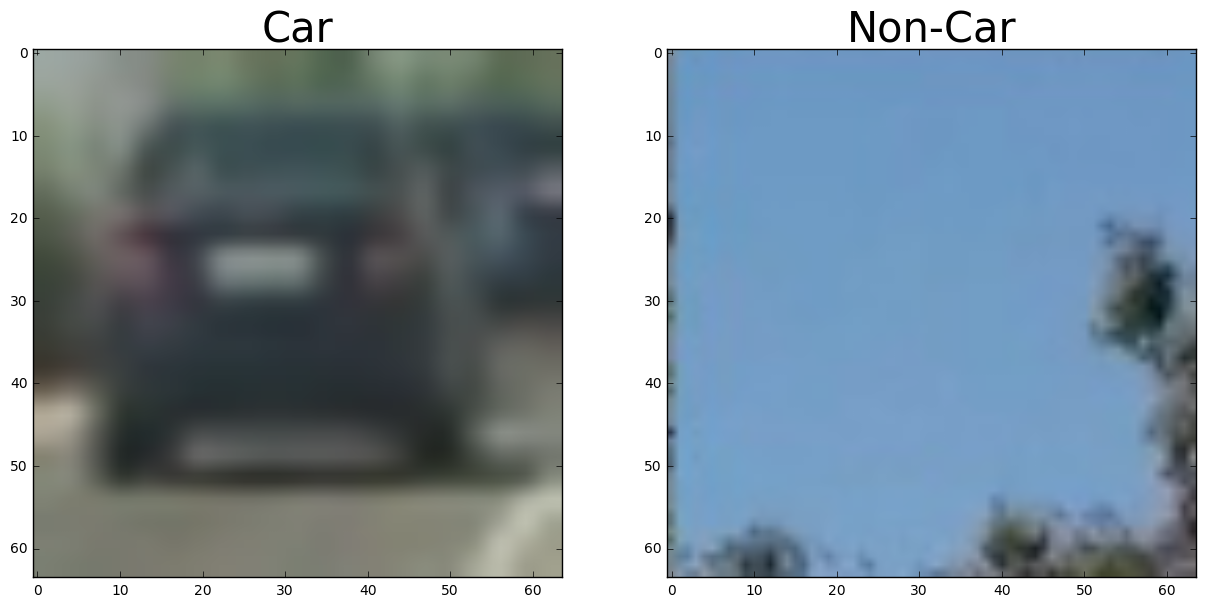

In [3]:
# Plot out a car and non car result
read_image = lambda image_path : (mpimg.imread(image_path) * 255).astype(np.uint8)
sample_vehicle = read_image(vehicles[0])
sample_nonvehicle = read_image(non_vehicles[0])

# Create the plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 30))
ax1.imshow(sample_vehicle)
ax1.set_title("Car", fontsize = 30)
ax2.imshow(sample_nonvehicle)
ax2.set_title("Non-Car", fontsize = 30)

## Extract features from images using various techniques

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# Test the function for both return types
orient = 9 # setting the number of bins so 9 bins would mean each bin is 40 degrees
pix_per_cell = 8 # setting the number of pixels that make up a cell, these cells are how the hog features are created
cell_per_block = 2 # this specifies the width/length of a square kernel


features_vehicle, hog_image_vehicle = get_hog_features(sample_vehicle[:,:,0], orient, pix_per_cell, cell_per_block, vis = True)
print("features.shape for feature_vector = True is: {}".format(features_vehicle.shape)) 

# as our picture is 64 x 64, we would have 64/8 = 8 cells on each side, so a total of 64 cells
# As each block contains 2 cells on each side or 4 cells in total there would be 2x2x9 features per block
# Therefore using a stride of 1, we would get 7 steps on either side of the image yielding 7x7x2x2x9 features
features_nonvehicle, hog_image_nonvehicle = get_hog_features(sample_nonvehicle[:,:,0], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = False)
print("features.shape for feature_vector = False is: {}".format(features_nonvehicle.shape)) 

features.shape for feature_vector = True is: (1764,)
features.shape for feature_vector = False is: (7, 7, 2, 2, 9)


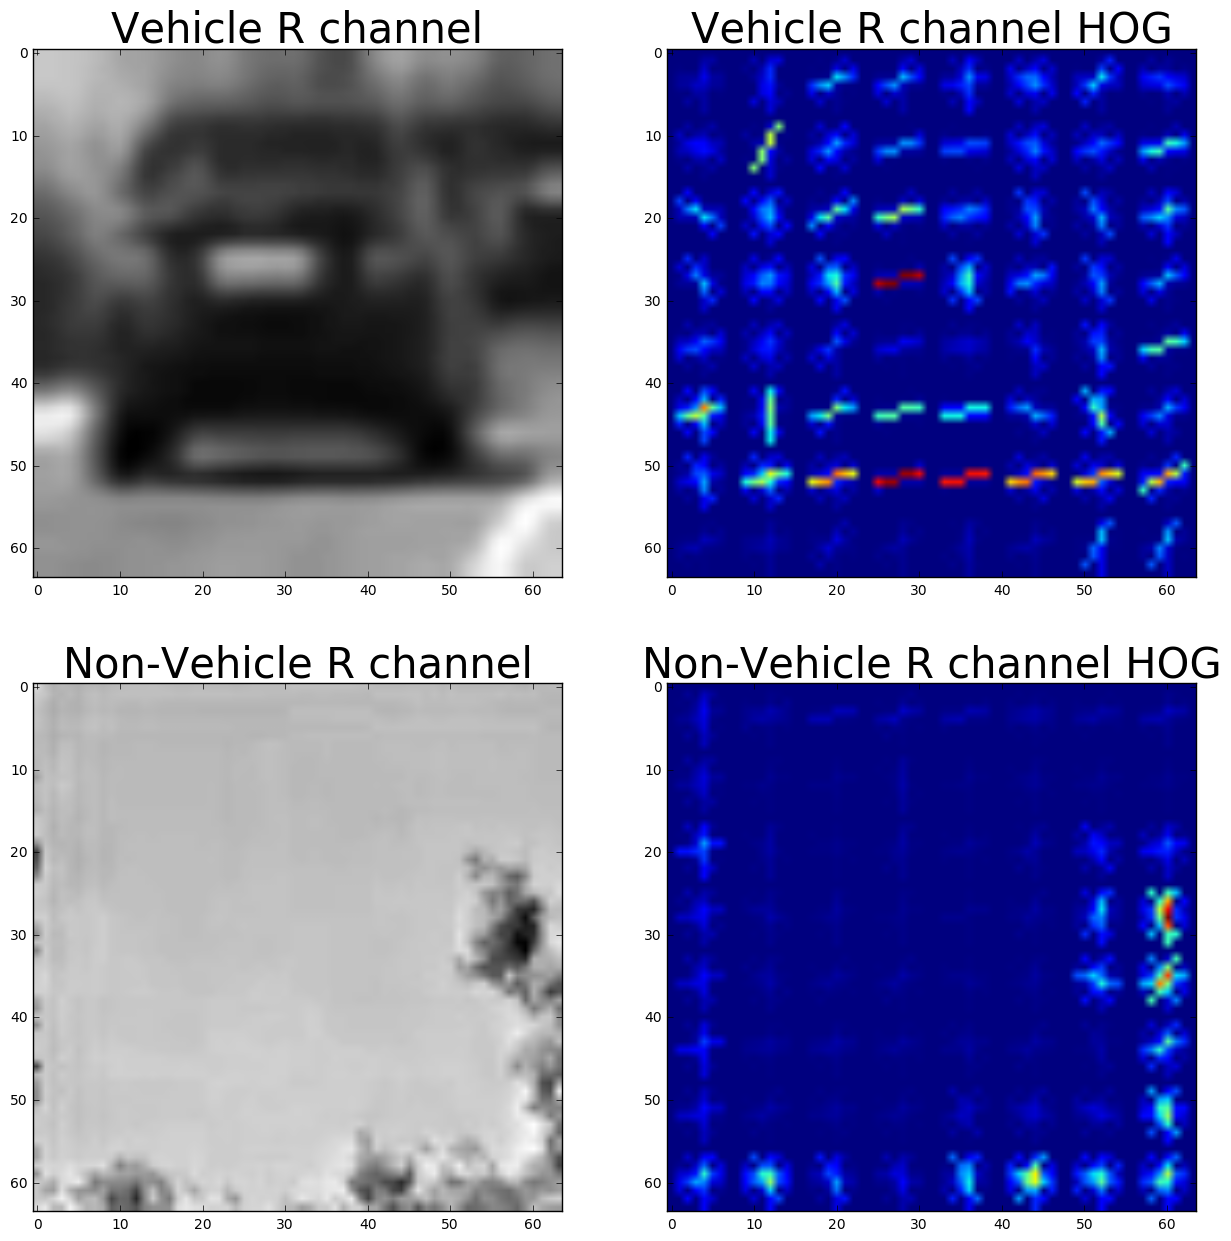

In [47]:
# Plot result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))
ax1.imshow(sample_vehicle[:,:,0], cmap = 'gray')
ax1.set_title("Vehicle R channel", fontsize = 30)
ax2.imshow(hog_image_vehicle)
ax2.set_title("Vehicle R channel HOG", fontsize = 30)
ax3.imshow(sample_nonvehicle[:,:,0], cmap = 'gray')
ax3.set_title("Non-Vehicle R channel", fontsize = 30)
ax4.imshow(hog_image_nonvehicle)
ax4.set_title("Non-Vehicle R channel HOG", fontsize = 30)

In [46]:
# Define a function to compute binned color features  

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [8]:
# Using the pure pixel values
spatial_features = bin_spatial(sample_vehicle)
print(spatial_features.shape)

(3072,)


In [9]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [10]:
# Using the binned pixel values
color_hist_features = color_hist(sample_vehicle)
print(color_hist_features.shape)

(96,)


In [11]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = (mpimg.imread(file) * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features 

## Train the Linear SVC

In [12]:
color_space = 'LAB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [13]:
def get_data(vehicles, non_vehicles, color_space, orient, pix_per_cell, \
             cell_per_block, hog_channel, spatial_size, hist_bins, \
             spatial_feat, hist_feat, hog_feat):
    vehicle_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    non_vehicle_features = extract_features(non_vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    return(scaled_X, y, X_scaler)

In [14]:
X, y, X_scaler = get_data(vehicles, non_vehicles, color_space, orient, \
                         pix_per_cell, cell_per_block, hog_channel, \
                         spatial_size, hist_bins, spatial_feat, \
                         hist_feat, hog_feat)

In [15]:
def train_svm(X, y):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    X_train, X_val, y_train,y_val = train_test_split(X_train, y_train, test_size = 0.2)
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = svm.LinearSVC()
    # Check the training time for the SVC
    svc.fit(X_train, y_train)
    # Check the score of the SVC
    print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return(svc) 

In [16]:
# Save the SVC and X_scaler
svc = train_svm(X, y)
model_info = {"model":svc, "scaler":X_scaler}
pickle.dump(model_info, open("model_{}.p".format(color_space), "wb"))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
Validation Accuracy of SVC =  0.9905
Test Accuracy of SVC =  0.9927


In [17]:
def load_model(color_space):
    model_info = pickle.load(open("model_{}.p".format(color_space), "rb"))
    svc = model_info["model"]
    X_scaler = model_info["scaler"]
    return(svc, X_scaler)

## Classify the boxes that were found and see if it is a car

In [18]:
def convert_color(image, color_space ='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        feature_image = np.copy(image)
    return(feature_image)

In [19]:
def find_cars(img, y_start, y_stop, scale , model, X_scaler, orient,\
             pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space,\
             hog_feat, spatial_feat, hist_feat):
    draw_img = np.copy(img)
    bboxes = []
    img_to_search = img[y_start:y_stop, :, :]
    color_space_to_search = convert_color(img_to_search, color_space = color_space)
    if scale != 1:
        # if scale > 1 the image becomes smaller
        # if scale < 1 the image becomes larger
        imshape = color_space_to_search.shape
        color_space_to_search = cv2.resize(color_space_to_search, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Get the color channels
    ch1 = color_space_to_search[:, :, 0]
    ch2 = color_space_to_search[:, :, 1]
    ch3 = color_space_to_search[:, :, 2]
    
    # Get the number of blocks in the image, so pix_per_cell number of pixels make up one cell/block
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    n_feat_per_block = orient * cell_per_block ** 2
    
    # Partition the image 
    window = 64 # number of pixels for the sides of a square
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # how many blocks we move by
    nxsteps = (nxblocks - n_blocks_per_window) // cells_per_step
    nysteps = (nyblocks - n_blocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            # See which "block" we are currently on
            ypos = yb * cells_per_step 
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            if hog_feat:
                hog_feat1 = hog1[ypos:ypos+n_blocks_per_window, xpos:xpos+n_blocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+n_blocks_per_window, xpos:xpos+n_blocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+n_blocks_per_window, xpos:xpos+n_blocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            # See what "pixel" we are currently on
            xleft = xpos * pix_per_cell 
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(color_space_to_search[ytop:ytop+window, xleft:xleft+window], (window, window))
            
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            else:
                spatial_features = np.array([])
            
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
            else:
                hist_features = np.array([])
            
#             print(hog_features.shape)
#             print(spatial_features.shape)
#             print(hist_features.shape)
            # Scale features and make a prediction
            final_features = np.hstack((spatial_features, hist_features, hog_features))
#             print(final_features.shape)
            test_features = X_scaler.transform(final_features.reshape(1, -1))    
            test_prediction = model.predict(test_features)
            
            # Calculate where the bboxes will be in the rescaled image
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            if test_prediction == 1:
                # scale up to original image size
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bboxes.append(bbox)
                cv2.rectangle(draw_img,bbox[0],bbox[1],(255,0,0),6)   
    return draw_img, bboxes
   

If the scale is < 1 than it means that the image will get scaled up. As the window size that we search in is fixed, this means that the boxes that are fitted on the image will be small. Ideally, we want to use different scales to detect cars, this is because cars are smaller in the distance and bigger when they are near us. By using a different scale to look at the images we are essentially changing the window size (as mentioned above. Due to the way that our classifiers are trained, we need the boxes that capture the car to look similar to the ones we have in our training images (i.e. only contain the car and nothing else). 

## Test to see if the pipeline for finding cars is working

In [20]:
# Setup the parameters
color_space = 'LAB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
ystart = 400
ystop = 656
hog_feat = True
spatial_feat = True
hist_feat = True

In [21]:
# Load up the model
svc, X_scaler = load_model(color_space)
scale = np.arange(0.9, 1.9, 0.2)
all_bboxes_LAB = []
out_imgs = []
print(scale)

[ 0.9  1.1  1.3  1.5  1.7]


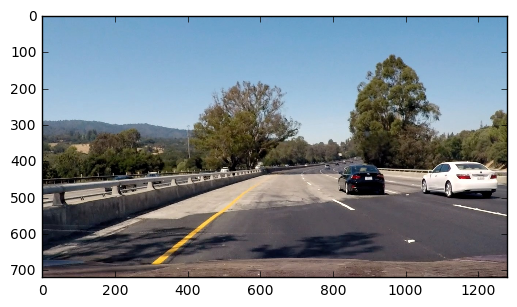

In [22]:
# Get a random image
LANE_LINES_FOLDER_NAME = "test_images"
lane_line_image_paths = glob.glob(os.path.join(LANE_LINES_FOLDER_NAME, '*.jpg'))
lane_line_images = [mpimg.imread(lane_line_image_path) for lane_line_image_path in lane_line_image_paths]
sample_image = lane_line_images[5]
plt.imshow(sample_image)

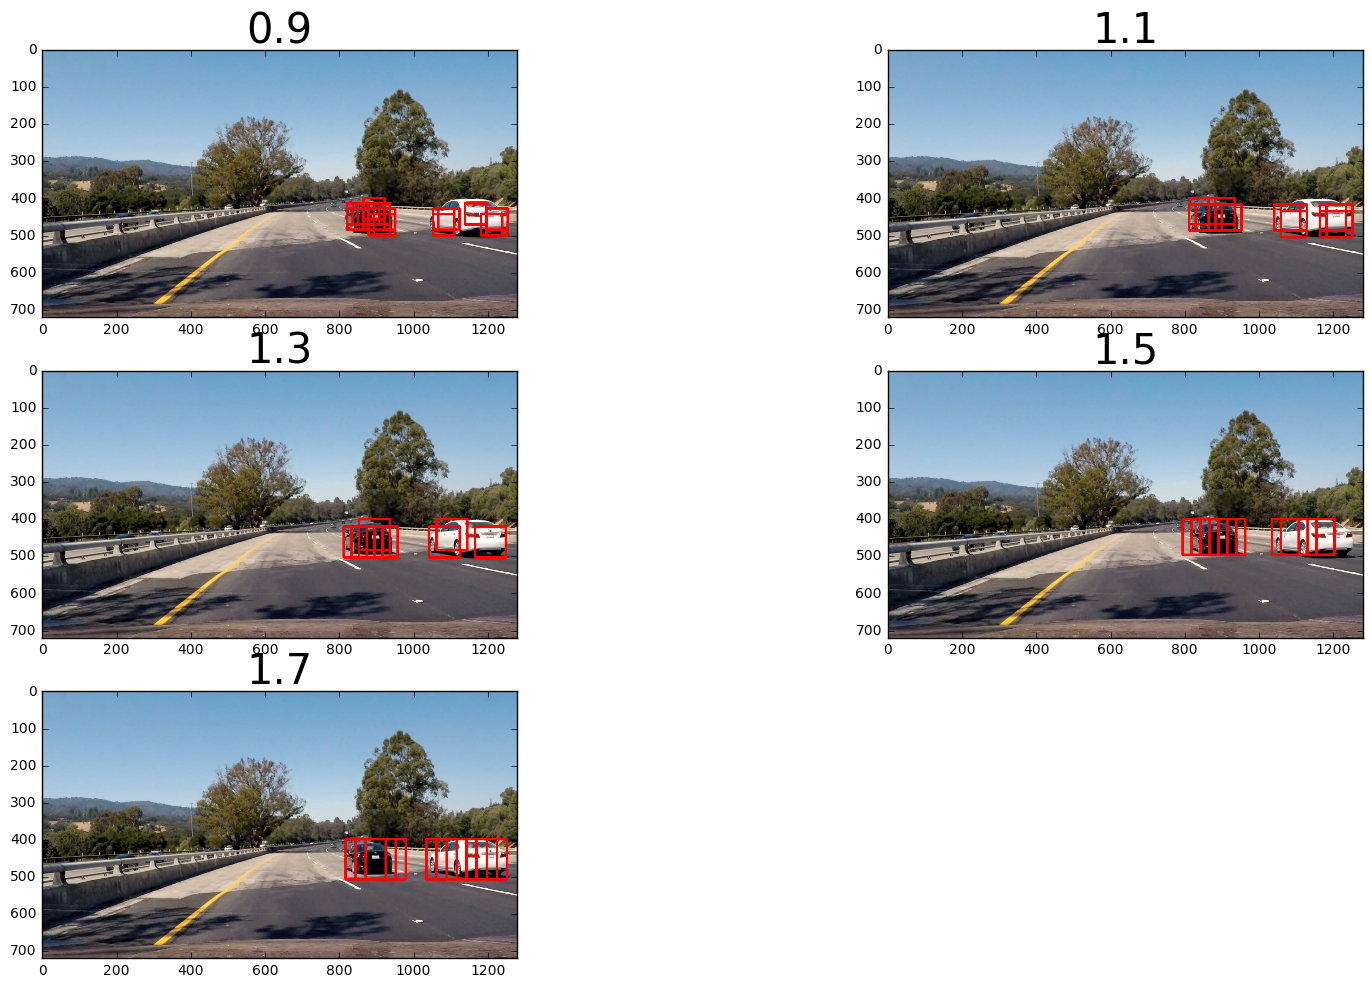

In [23]:
fig = plt.figure(figsize=(20, 20))
for i, scale_coef in enumerate(scale):
    out_img, bboxes = find_cars(sample_image, ystart, ystop, scale_coef, svc, \
                                X_scaler, orient, pix_per_cell, cell_per_block, \
                                spatial_size, hist_bins, color_space, hog_feat, spatial_feat, hist_feat)
    for bbox in bboxes:
        all_bboxes_LAB.append(bbox)
        
    ax = fig.add_subplot(5,2,i+1)
    ax.set_title(scale[i], fontsize = 30)
    ax.imshow(out_img)

### It seems like the LAB color space is doing a good job finding the cars, but maybe the HSV color space will be even better?

In [24]:
# try using HSV color space
color_space = "HSV"
svc, X_scaler = load_model(color_space)
all_bboxes_HSV = []

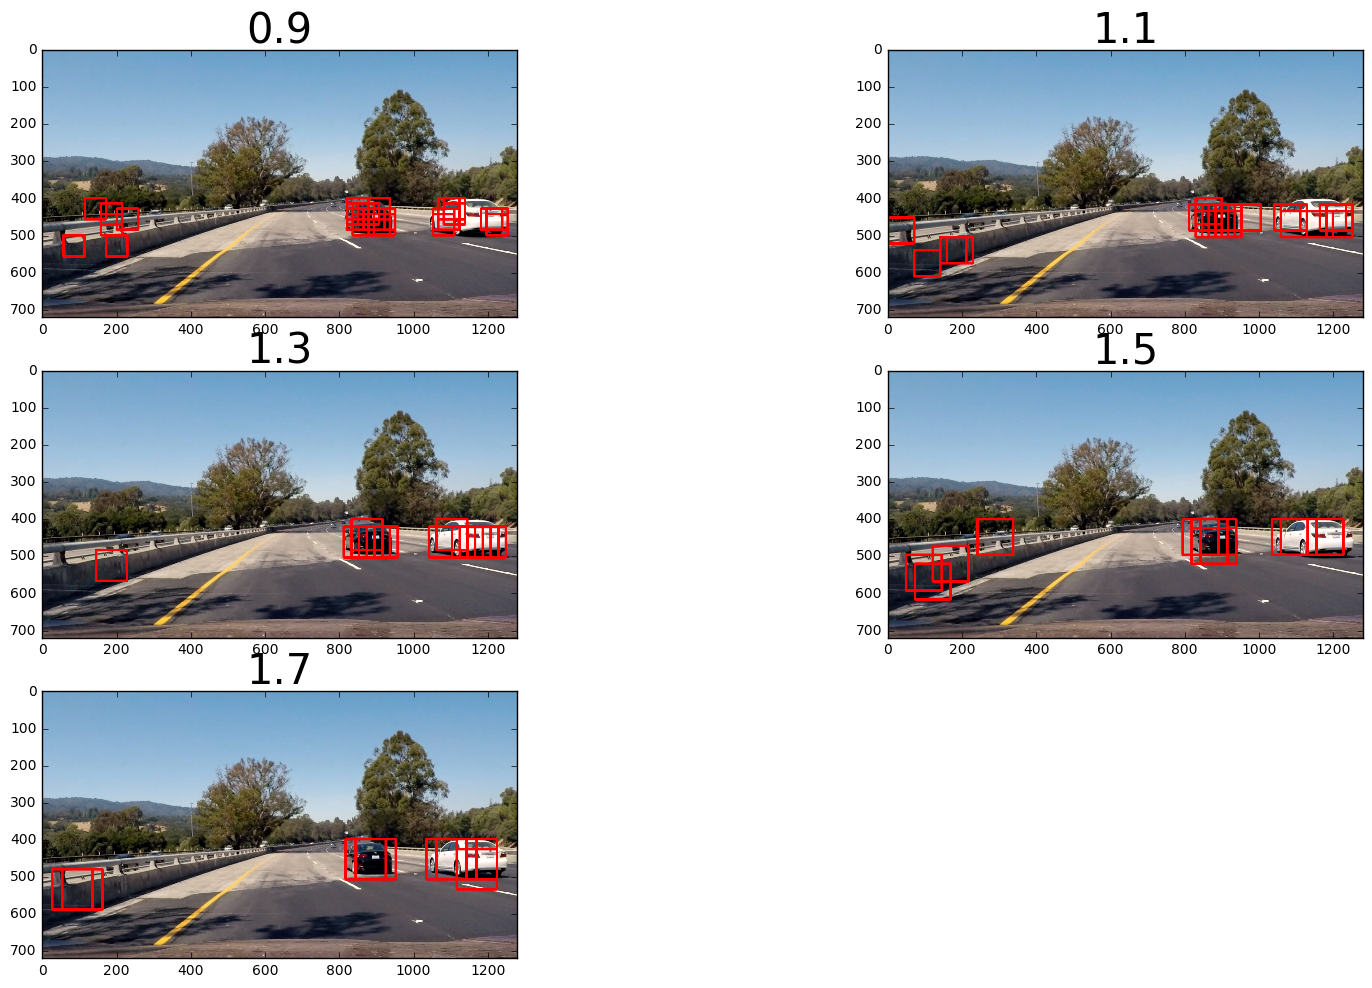

In [25]:
fig = plt.figure(figsize=(20, 20))
for i, scale_coef in enumerate(scale):
    out_img, bboxes = find_cars(sample_image, ystart, ystop, scale_coef, svc, \
                                X_scaler, orient, pix_per_cell, cell_per_block, \
                                spatial_size, hist_bins, color_space, hog_feat, spatial_feat, hist_feat)
    for bbox in bboxes:
        all_bboxes_HSV.append(bbox)
        
    out_imgs.append(out_img)
    ax = fig.add_subplot(5,2,i+1)
    ax.set_title(scale[i], fontsize = 30)
    ax.imshow(out_img)

We see here that the HSV channel picks up a lot more noise than the LAB channel, so I will be using the LAB channel

## Using a heat map to decide how many cars are in our image

In [26]:
from scipy.ndimage.measurements import label
def add_heat(heat, bboxes):
    for bbox in bboxes:
        heat[bbox[0][1] : bbox[1][1], bbox[0][0] : bbox[1][0]] += 1
    return heat

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define the largest possible bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

### See what the heat map for the LAB color channel looks like 

labels[0] is: (720, 1280)
There are: 2 cars


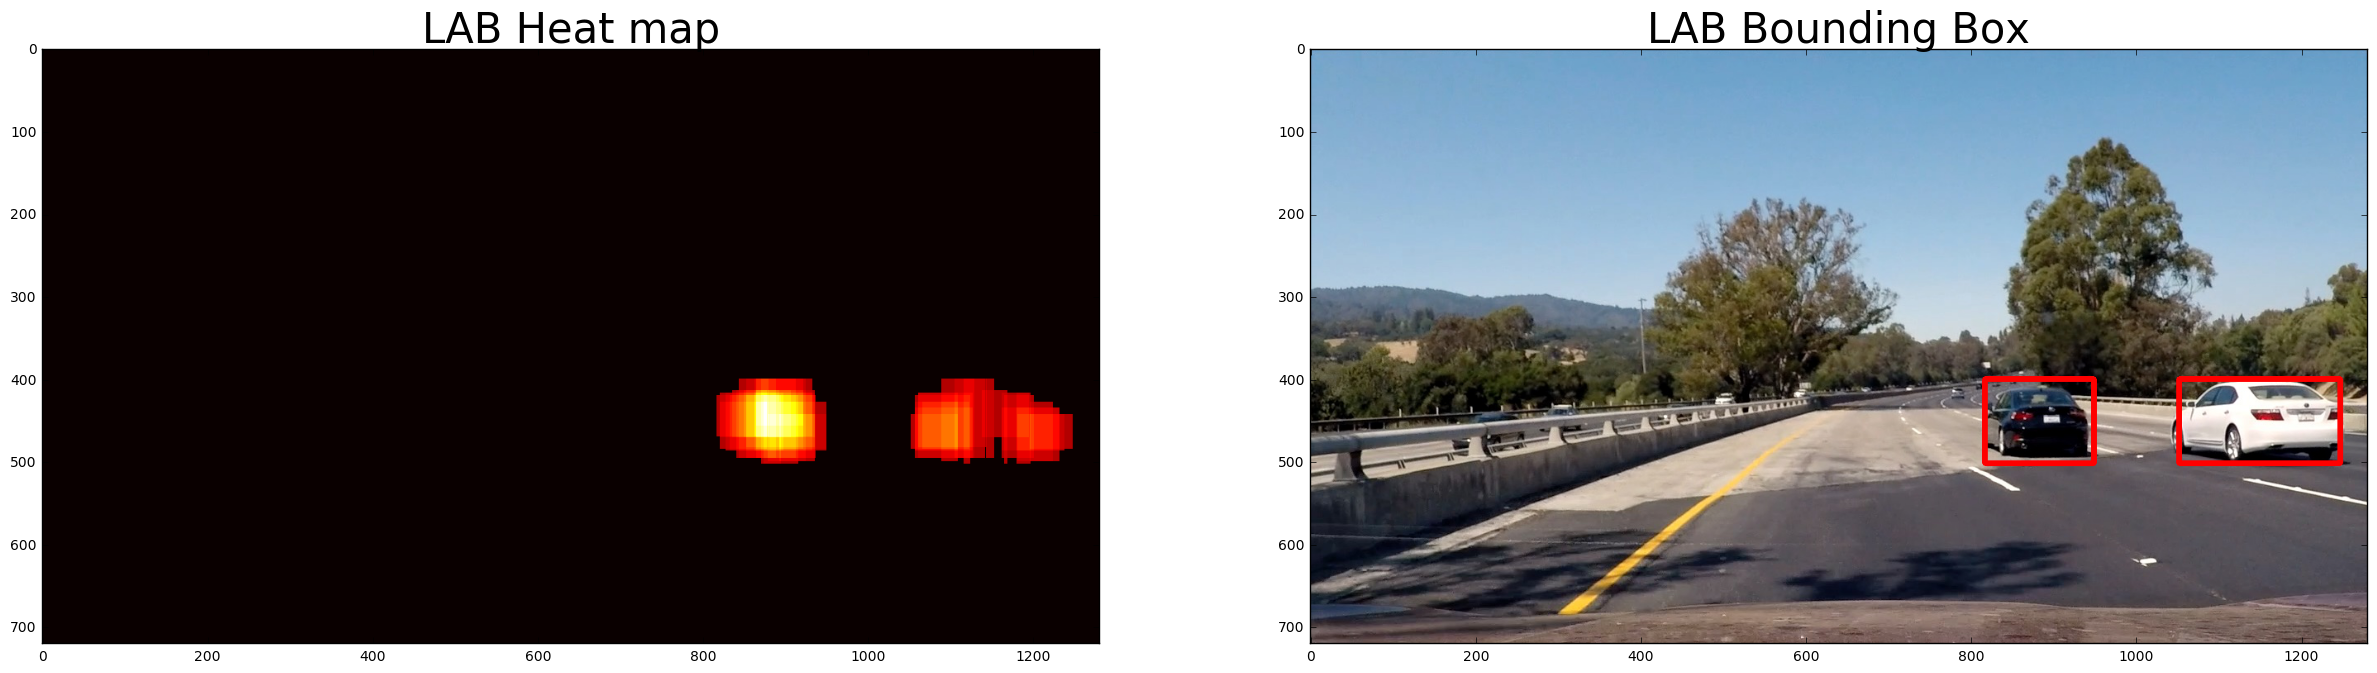

In [48]:
# create heat map
heat = np.zeros_like(sample_image[:,:,0])

# add heat
heat = add_heat(heat, all_bboxes_LAB)

# threshold it to avoid false positives
heat = apply_threshold(heat, 5)

# find the number of cars
labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(sample_image), labels)
print("labels[0] is: {}".format(labels[0].shape))
print("There are: {} cars".format(labels[1]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 30))
ax1.imshow(heat, cmap = 'hot') 
ax1.set_title("LAB Heat Map", fontsize = 30)
ax2.imshow(draw_img)
ax2.set_title("LAB Bounding Box", fontsize = 30)

### See what the heat map for the HSV color channel looks like

There are: 4 car(s)


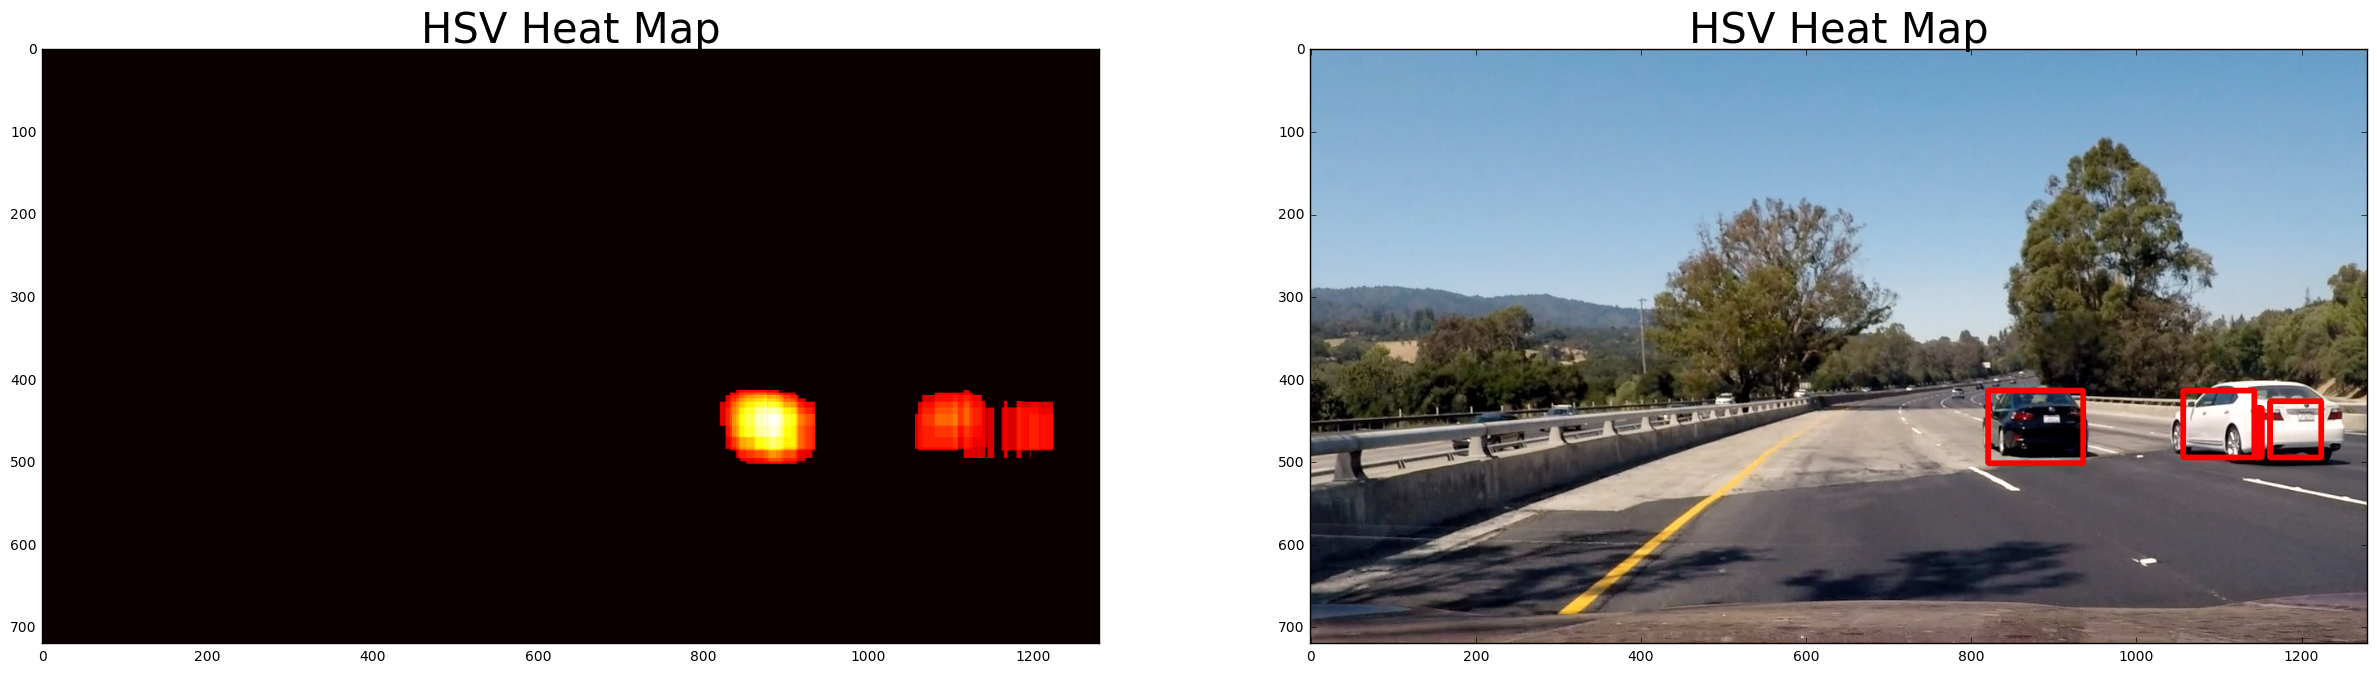

In [49]:
# create heat map
heat = np.zeros_like(sample_image[:,:,0])

# add heat
heat = add_heat(heat, all_bboxes_HSV)

# threshold it to avoid false positives
heat = apply_threshold(heat, 8)

# find the number of cars
labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(sample_image), labels)
print("There are: {} car(s)".format(labels[1]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 15))
ax1.imshow(heat, cmap = 'hot') 
ax1.set_title("HSV Heat Map", fontsize = 30)
ax2.imshow(draw_img)
ax2.set_title("HSV Heat Map", fontsize = 30)

### See what the heat map for the HSV+LAB color channel looks like

There are: 2 car(s)


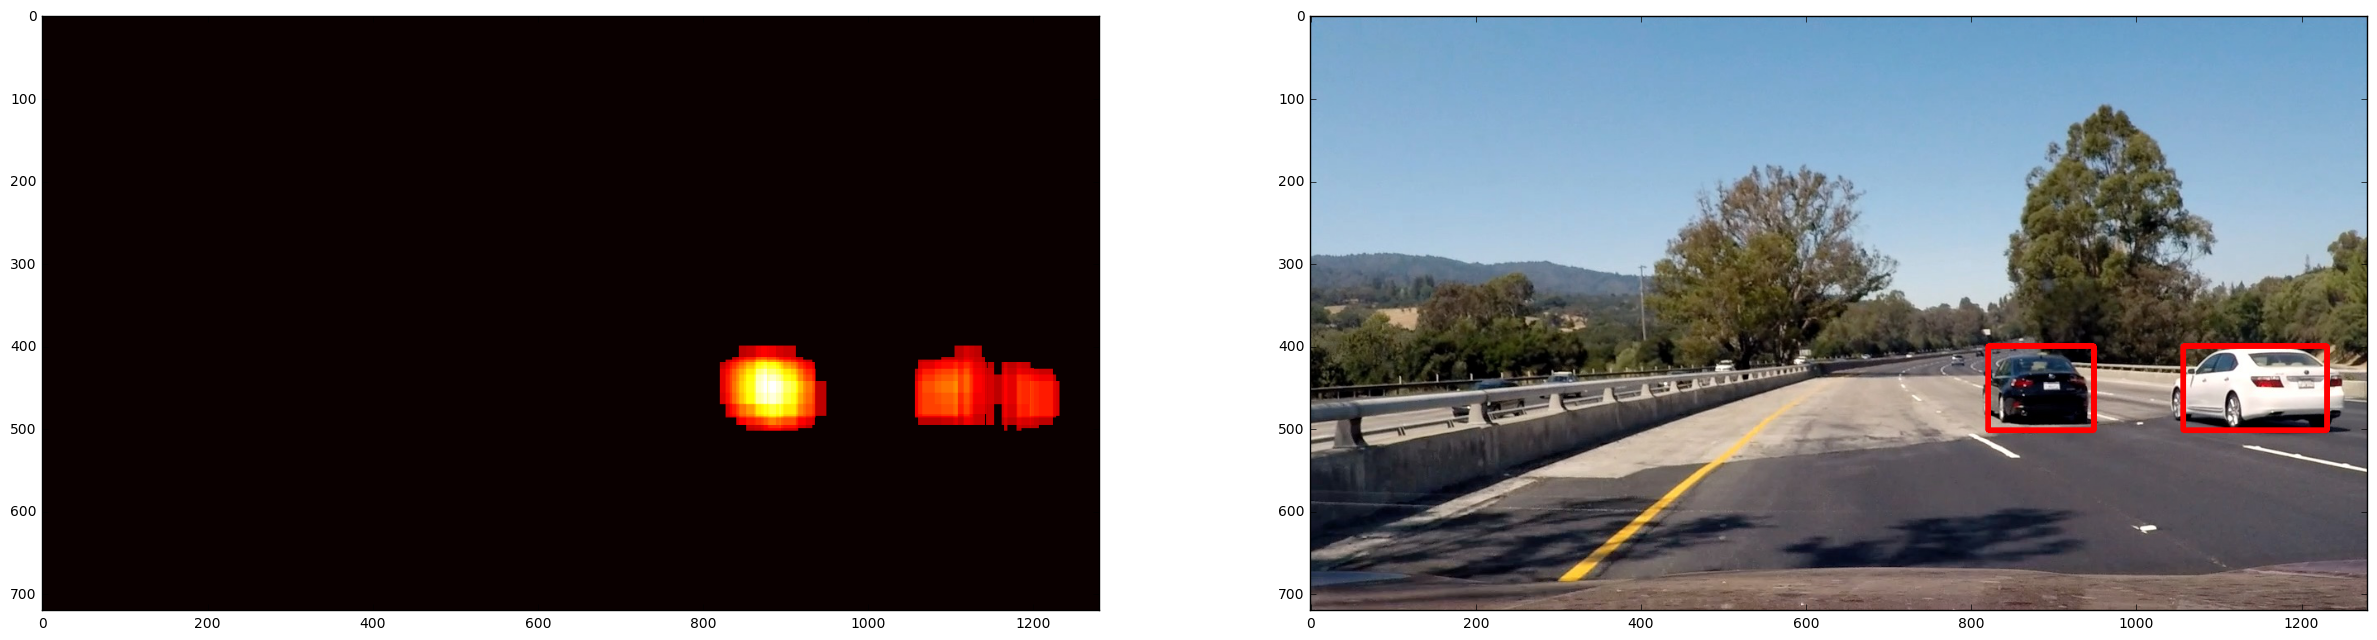

In [29]:
# create heat map
heat = np.zeros_like(sample_image[:,:,0])

# add heat
heat = add_heat(heat, all_bboxes_HSV + all_bboxes_LAB)

# threshold it to avoid false positives
heat = apply_threshold(heat, 13)

# find the number of cars
labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(sample_image), labels)
print("There are: {} car(s)".format(labels[1]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 15))
ax1.imshow(heat, cmap = 'hot') 
ax2.imshow(draw_img)

# Using non-maximum suppression to see how many cars are in our image

In [30]:
def nms(bboxes, overlapThreshold):
    
    # Check if the bboxes list is empty
    if len(bboxes) == 0:
        return[]
    
    # Turn the list into type float
    if bboxes.dtype.kind == "i":
        bboxes = bboxes.astype(np.float)
        
    # Define the list which will store the picked boxes
    pick = []
    
    # Define the points that define the corners of the bboxes
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    
    # Calculate the area
    area = (x2 - x1 + 1 ) * (y2 - y1 + 1)
#     print(area)
    # Sort the boxes by the bottom-right y-coordinate of the bounding box 
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        
        # Get the most bottom right bbox that is left in the array 
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # find the smallest possible bbox of all the bboxes that are left
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # Finding the overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # delete all the indexes from the index list that overlapped, the lower the threshold, the more boxes get
        # filtered out
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThreshold)[0])))
        
    
    return(bboxes[pick].astype(np.int))

### Using the LAB channel 

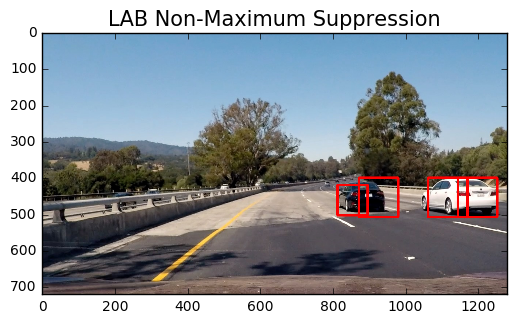

In [51]:
concat_all_bboxes_nms = np.array([[bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]] for bbox in all_bboxes_LAB])
# for bbox in concat_all_bboxes:
#     print(bbox[0][0])
bboxes_nms = nms(concat_all_bboxes_nms, 0.5)

all_bboxes_nms = [((x1, y1), (x2,y2)) for x1,y1,x2,y2 in bboxes_nms]
    
out_img = sample_image.copy()
for p1, p2 in all_bboxes_nms:
    cv2.rectangle(out_img, p1, p2, (255, 0, 0), 5)
plt.imshow(out_img)
plt.title("LAB Non-Maximum Suppression", fontsize = 15)

### Using the HSV channel

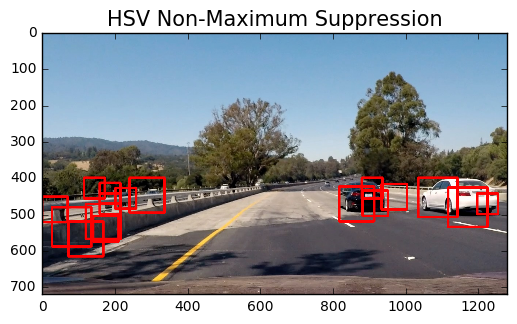

In [52]:
concat_all_bboxes_nms = np.array([[bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]] for bbox in all_bboxes_HSV])
# for bbox in concat_all_bboxes:
#     print(bbox[0][0])
bboxes_nms = nms(concat_all_bboxes_nms, 0.5)

all_bboxes_nms = [((x1, y1), (x2,y2)) for x1,y1,x2,y2 in bboxes_nms]
    
out_img = sample_image.copy()
for p1, p2 in all_bboxes_nms:
    cv2.rectangle(out_img, p1, p2, (255, 0, 0), 5)
plt.imshow(out_img)
plt.title("HSV Non-Maximum Suppression", fontsize = 15)

Seems like non-maximum suppression doesn't work that well, although this may be because the bboxes that we produced at of only square sizes and not rectangles like the one that exists in facenet

# Setup the pipeline for detecting cars 

In [33]:
class HeatmapContainer:
    def __init__(self, n = 10):
        self.heatmaps = []
        self.n = n
    def append_to_heatmaps(self, heatmap):
        if len(self.heatmaps) >= self.n:
            # insert to start of the list
            self.heatmaps.insert(0, heatmap)
            
            # then pop the last heatmap off
            self.heatmaps.pop(-1)
        else:
            self.heatmaps.insert(0, heatmap)
            
    def get_stacked_heatmaps(self): 
        if len(self.heatmaps) == 0:
            return([]) 
        stacked_heatmap = np.zeros_like(self.heatmaps[0]) 
        for heatmap in self.heatmaps:
            stacked_heatmap += np.array(heatmap)
        return(stacked_heatmap)
        
    

In [34]:
def process_image_vehicle_detection_stacked_heatmap(image, debug = False, labels = False):
    """
    Note here that the svc is trained on a HSV image, and so the image is 
    changed to HSV color space in find_cars function when the classfications
    are being made
    """
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    y_start_stop = [400, 720] # Min and max in y to search in slide_window()
    ystart = 400 # where to start the search for vehicles
    ystop = 656 # where to stop the searcch for vehicles 
    scale = np.arange(0.9, 1.9, 0.2)
    color_space = "LAB"
    hog_feat = True
    spatial_feat = True
    hist_feat = True
    all_bboxes = []
    
    
    
    # Loading the model with respect to the color space that is being used
    svc, X_scaler = load_model(color_space)
    
    # Get the out_img and also the bboxes
    for i, scale_coef in enumerate(scale):
        out_img, bboxes = find_cars(image, ystart, ystop, scale_coef, svc, X_scaler, \
                                    orient, pix_per_cell, cell_per_block, spatial_size, \
                                    hist_bins, color_space, hog_feat, spatial_feat, hist_feat)
        for bbox in bboxes:
            # append the bboxes for heat map
            all_bboxes.append(bbox)
    
    # empty heat map
    heatmap = np.zeros_like(image[:,:,0])

    # add heat
    heatmap = add_heat(heatmap, all_bboxes)
    heatmapContainer.append_to_heatmaps(heatmap)
    
    stacked_heatmap = heatmapContainer.get_stacked_heatmaps()
    
    # threshold it to avoid false positives
    stacked_heatmap_thresholded = apply_threshold(stacked_heatmap, 12)
    
    # find the number of cars
    labels = label(stacked_heatmap_thresholded)
    
    # return final image
    heat_bboxes_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if debug: 
        return(out_img, heat_bboxes_img, stacked_heatmap_thresholded)
    elif label:
        return(labels)
    else:
        return(heat_bboxes_img)
        

#### Some helper function to extract some frames from the video

In [35]:
def load_video(video_name):
    return(pickle.load(open("{}_video.p".format(video_name), "rb"))[video_name])

def save_video(video_name, video_frames):
    video_frames = np.array(video_frames)
    video_trim = {video_name : video_frames}
    pickle.dump(video_trim, open("{}_video.p".format(video_name), "wb"))

In [36]:
# NOTE: Uncomment below if the video needs to be saved again
# video_frames = []
# def add_video_frames(image):
#     video_frames.append(image)
#     return(image) 
# project_video_output = 'placeholder.mp4'
# clip1 = VideoFileClip("white_car.mp4")
# project_video_clip = clip1.fl_image(add_video_frames) #NOTE: this function expects color images!!
# %time project_video_clip.write_videofile(project_video_output, audio=False)

# save_video("white_car", video_frames)

white_car = load_video("white_car")
white_car.shape

(276, 720, 1280, 3)

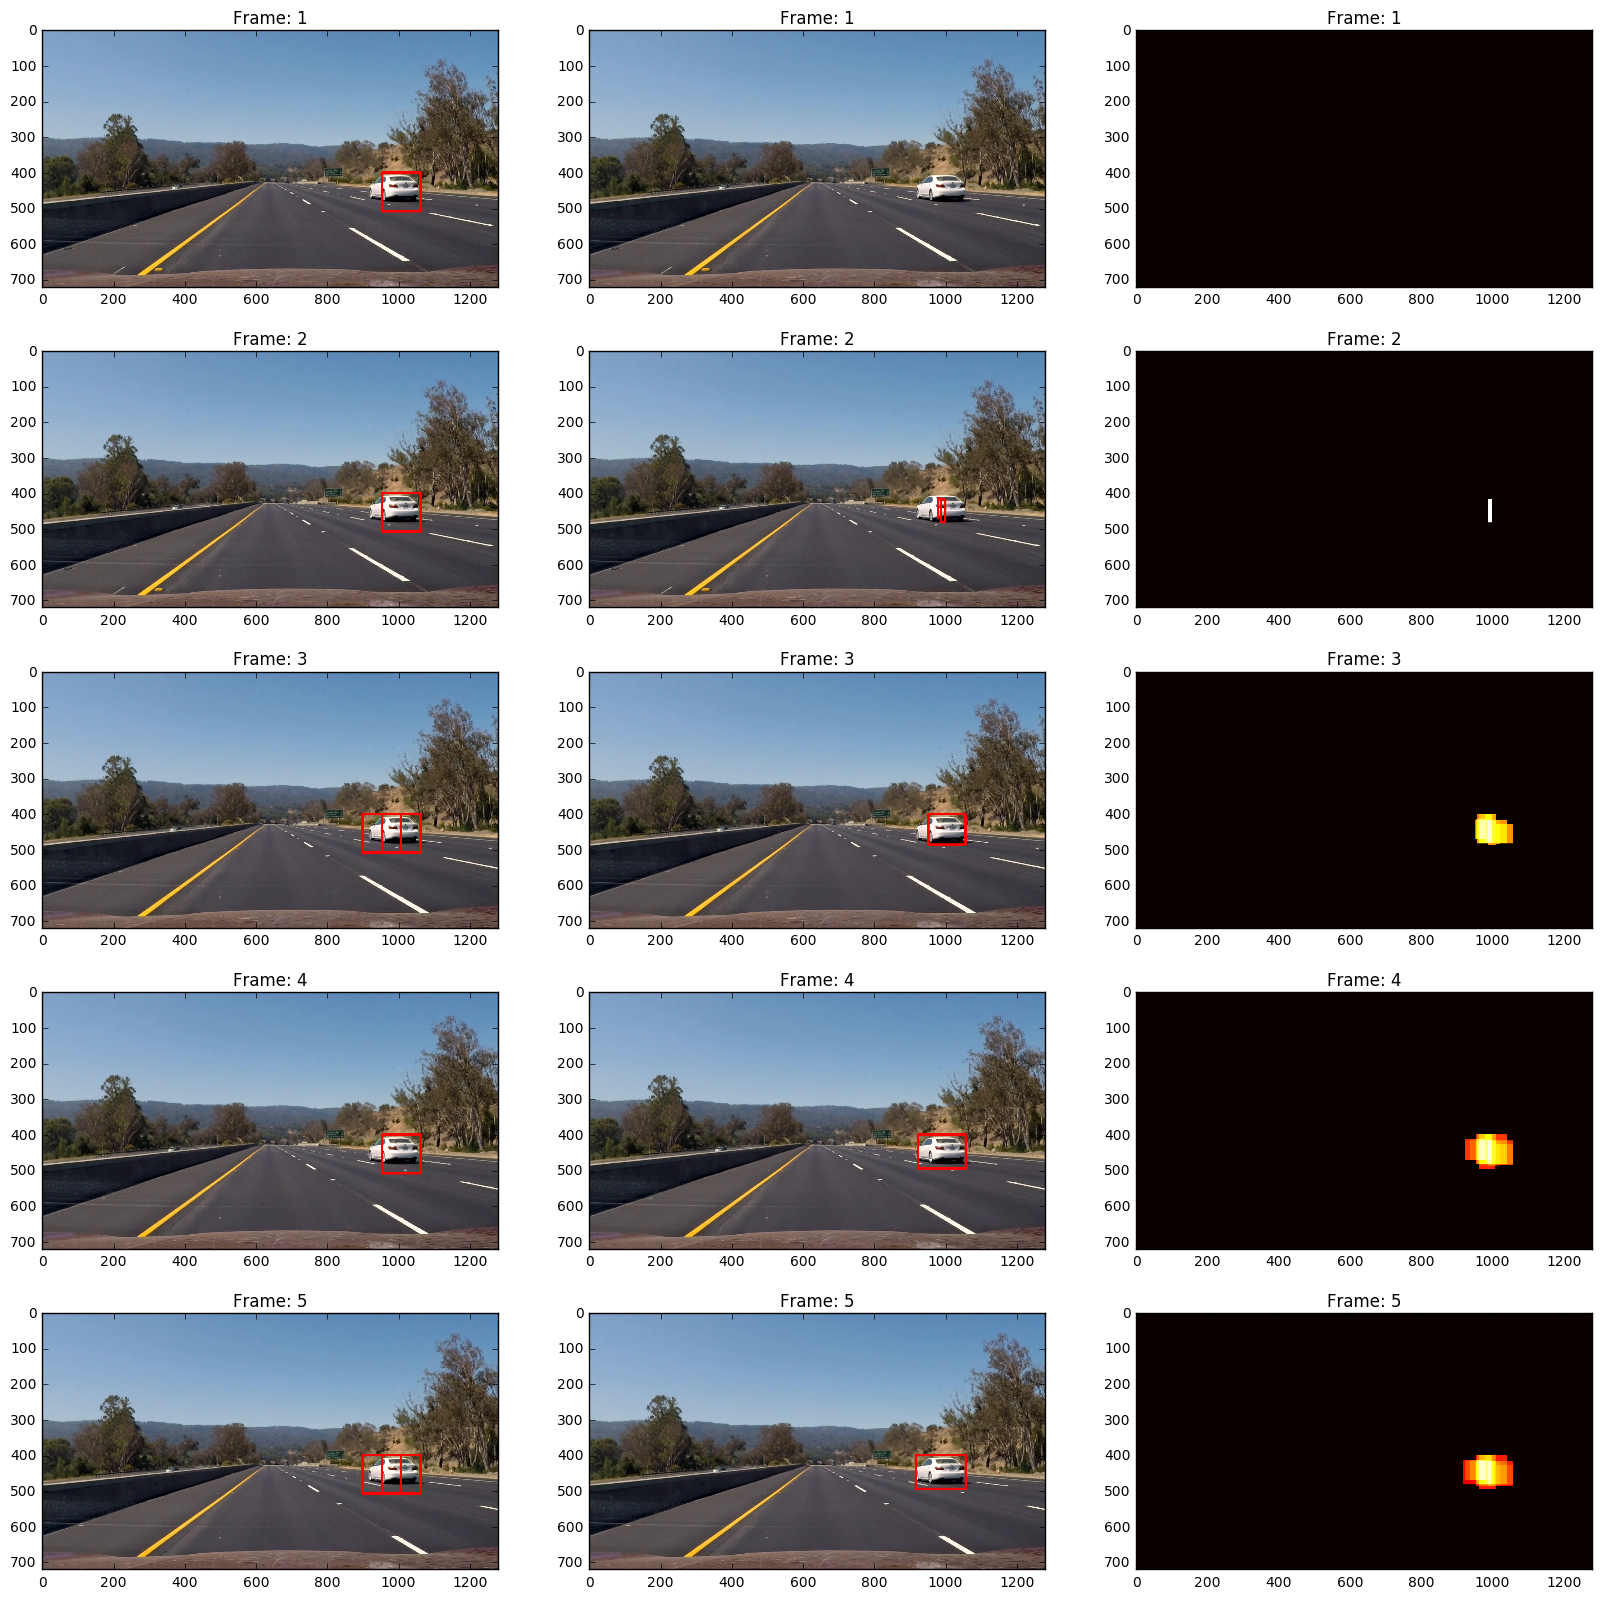

In [37]:
# See some output from the function
import matplotlib.gridspec as gridspec

heatmapContainer = HeatmapContainer()
fig = plt.figure(figsize = (20, 20))
gs = gridspec.GridSpec(5, 3)
for i, frame in enumerate(white_car[0:5:]):
    bboxes, thresh_bboxes, heatmap = process_image_vehicle_detection_stacked_heatmap(frame, debug = True)
    for j, image in enumerate([bboxes, thresh_bboxes, heatmap]):
        ax = fig.add_subplot(gs[i,j])
        if j != 2:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap = 'hot')
        ax.set_title("Frame: {}".format(i+1))

## Running the detection algorithm on the video

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [268]:
# This cell is for debugging purposes so that I can run my vehicle recognition software on 
# small parts of the video
heatmapContainer = HeatmapContainer()
time = "38-45"
project_video_output = '{}result.mp4'.format(time)
clip1 = VideoFileClip("{}.mp4".format(time))
project_video_clip = clip1.fl_image(process_image_vehicle_detection_stacked_heatmap) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video 38-45result.mp4
[MoviePy] Writing video 38-45result.mp4





  0%|          | 0/168 [00:00<?, ?it/s]


  1%|          | 1/168 [00:04<11:08,  4.00s/it]


  1%|          | 2/168 [00:07<11:03,  4.00s/it]


  2%|▏         | 3/168 [00:11<10:39,  3.88s/it]


  2%|▏         | 4/168 [00:14<10:03,  3.68s/it]


  3%|▎         | 5/168 [00:17<09:29,  3.49s/it]


  4%|▎         | 6/168 [00:21<09:08,  3.39s/it]


  4%|▍         | 7/168 [00:23<08:29,  3.16s/it]


  5%|▍         | 8/168 [00:26<07:57,  2.99s/it]


  5%|▌         | 9/168 [00:29<07:56,  3.00s/it]


  6%|▌         | 10/168 [00:32<07:58,  3.03s/it]


  7%|▋         | 11/168 [00:35<08:02,  3.08s/it]


  7%|▋         | 12/168 [00:38<08:04,  3.10s/it]


  8%|▊         | 13/168 [00:41<08:01,  3.11s/it]


  8%|▊         | 14/168 [00:45<08:13,  3.20s/it]


  9%|▉         | 15/168 [00:48<08:14,  3.23s/it]


 10%|▉         | 16/168 [00:53<09:27,  3.74s/it]


 10%|█         | 17/168 [00:56<08:52,  3.53s/it]


 11%|█         | 18/168 [00:59<08:23,  3.36s/it]


 11%|█▏        | 19/168 [01:02<08:12,  3.31s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: 38-45result.mp4 

CPU times: user 8min 1s, sys: 14.4 s, total: 8min 15s
Wall time: 8min 45s


In [ ]:
heatmapContainer = HeatmapContainer()
project_video_output = 'project_video_result_stacked_LAB_v3_n10_t12.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image_vehicle_detection_stacked_heatmap) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_result_stacked_LAB_v3_n10_t12.mp4
[MoviePy] Writing video project_video_result_stacked_LAB_v3_n10_t12.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:03<1:06:13,  3.15s/it]



  0%|          | 2/1261 [00:06<1:08:11,  3.25s/it]



  0%|          | 3/1261 [00:09<1:07:21,  3.21s/it]



  0%|          | 4/1261 [00:12<1:04:21,  3.07s/it]



  0%|          | 5/1261 [00:15<1:06:08,  3.16s/it]



  0%|          | 6/1261 [00:18<1:04:52,  3.10s/it]



  1%|          | 7/1261 [00:22<1:05:27,  3.13s/it]



  1%|          | 8/1261 [00:25<1:05:11,  3.12s/it]



  1%|          | 9/1261 [00:27<1:03:30,  3.04s/it]



  1%|          | 10/1261 [00:31<1:04:56,  3.11s/it]



  1%|          | 11/1261 [00:34<1:05:15,  3.13s/it]



  1%|          | 12/1261 [00:37<1:01:48,  2.97s/it]



  1%|          | 13/1261 [00:40<1:05:39,  3.16s/it]



  1%|          | 14/1261 [00:43<1:04:24,  3.10s/it]



  1%|          | 15/1261 [00:47<1:07:26,  3.25s/it]



  1%|▏         | 16/1261 [00:51<1:11:10,  3.43s/it]



  1%|▏         | 17/1261 [00:53<1:07:39,  3.26s/it]



  1%|▏         | 18/1261 [

In [ ]:
# Combine the lane detection algorithm and the vehicle detection algorithm